## Deep Learning
Assignment 2
Previously in 1_notmnist.ipynb, we created a pickle with formatted datasets for training, development and testing on the notMNIST dataset.
The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [3]:
# First reload the data we generated in 1_notmnist.ipynb.
pickle_file = 'proj1/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


## Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [10]:
(np.arange(10) == train_labels[:, None]).astype(np.float32)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [14]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)



Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


## We're first going to train a multinomial logistic regression using simple gradient descent.
TensorFlow works like this:
- First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:
 - with graph.as_default():
    ...
- Then you can run the operations on this graph as many times as you want by calling session.run(), providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:
 - with tf.Session(graph=graph) as session:
    ...
Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [48]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()

with graph.as_default():
    
    # input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph
    
    tf_train_dataset = tf.constant(train_dataset[:train_subset,:])
    tf_train_labels  = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    
    weights = tf.Variable(
       tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    
    logits = tf.matmul(tf_train_dataset, weights) + biases # 10000*784, 784*10
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    Optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)

    # Predictions for training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
      tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    



In [49]:
# Let's run this computation and iterate
num_steps = 801
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions,1) == np.argmax(labels,1))
            / predictions.shape[0])
            


In [50]:
with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized
    # as we described in the graph: random weights for the matrix, zeros for the
    # biases.
    tf.initialize_all_variables().run()
    loss_step = np.zeros(num_steps)
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimization
        # and get the loss value and the training predictions returned as numpy arrays.
        _, l, predictions = session.run([Optimizer, loss, train_prediction])
        if (step % 100 ==0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset,:]))
            # Calling .eval() on validation_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
            loss_step[step] = l
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
            

Initialized
Loss at step 0: 17.742443
Training accuracy: 10.1%
Validation accuracy: 12.1%
Loss at step 100: 3.135331
Training accuracy: 65.2%
Validation accuracy: 64.7%
Loss at step 200: 2.511221
Training accuracy: 70.5%
Validation accuracy: 69.9%
Loss at step 300: 2.213970
Training accuracy: 72.8%
Validation accuracy: 71.8%
Loss at step 400: 2.023722
Training accuracy: 74.1%
Validation accuracy: 72.8%
Loss at step 500: 1.885857
Training accuracy: 75.0%
Validation accuracy: 73.4%
Loss at step 600: 1.778369
Training accuracy: 75.4%
Validation accuracy: 74.0%
Loss at step 700: 1.690418
Training accuracy: 75.9%
Validation accuracy: 74.5%
Loss at step 800: 1.615945
Training accuracy: 76.4%
Validation accuracy: 74.7%
Test accuracy: 74.6%


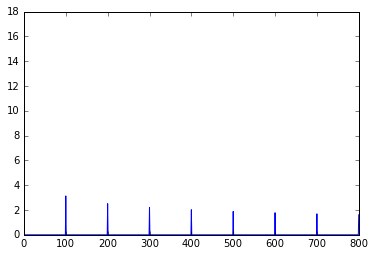

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_step)

## Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of session.run().

In [26]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that 
    # will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    weights = tf.Variable(
       tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
          tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

[array([[ 12.]], dtype=float32)]


In [40]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0]-batch_size)

Help on class GradientDescentOptimizer in module tensorflow.python.training.gradient_descent:

class GradientDescentOptimizer(tensorflow.python.training.optimizer.Optimizer)
 |  Optimizer that implements the gradient descent algorithm.
 |  
 |  @@__init__
 |  
 |  Method resolution order:
 |      GradientDescentOptimizer
 |      tensorflow.python.training.optimizer.Optimizer
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, learning_rate, use_locking=False, name='GradientDescent')
 |      Construct a new gradient descent optimizer.
 |      
 |      Args:
 |        learning_rate: A Tensor or a floating point value.  The learning
 |          rate to use.
 |        use_locking: If True use locks for update operations.
 |        name: Optional name prefix for the operations created when applying
 |          gradients. Defaults to "GradientDescent".
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from tens